In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import ast
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Get the sources and scope of the data
training_folder = "/home/kevin/Documents/udacity_car/term3/group_training_data_gen/sim_training_data"
annotation_folder = "/home/kevin/Documents/udacity_car/term3/group_training_data_gen/sim_training_data/annotations"
files = [x.split(".")[0] for x in os.listdir(training_folder) if x != 'annotations']
files.sort()
indexes = [int(x) for x in files]

In [3]:
# Read the annovations and store the x, y, w, h coordinates to a dataframe
annotations = pd.DataFrame(index=indexes, columns=['x', 'y', 'w', 'h', 'label'])
for index, file in zip(indexes, files):
    with open(annotation_folder + "/" + file + ".json", 'r') as openfile:
        details = ast.literal_eval(openfile.read())
    line = details['objects'][0]['x_y_w_h']
    line.append(details['objects'][0]['label'])
    annotations.loc[index] = line

In [4]:
# We'll use median width and height for the deciding on image resizes
mw = int(annotations['w'].median())
mh = int(annotations['h'].median())
print("We'll resize all these zoomed images to {0}x{1} pixels".format(mw, mh))

We'll resize all these zoomed images to 26x176 pixels


In [5]:
# Helper function for plotting an image with rectangle drawn given an index
def draw_rect_image(index):
    file = str(index).zfill(4)
    left = annotations.loc[index, 'x']
    right = left + annotations.loc[index, 'w']
    top = annotations.loc[index, 'y']
    bottom = top + annotations.loc[index, 'h']
    image = cv2.cvtColor(cv2.imread(training_folder + "/" + file + ".jpg"), cv2.COLOR_BGR2RGB)
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 4)
    plt.imshow(image)
    plt.show()
    plt.clf()

traffic_light-red


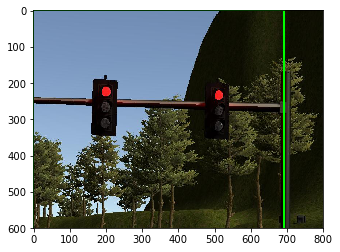

In [6]:
# Grab a random image and plot the rectangle as a dummy check
sample = random.choice(indexes)
print(annotations.loc[sample, 'label'])
draw_rect_image(sample)

In [7]:
# Read in each file, zoom to the annotated spot, resize to the standard, then save the color histogram features
cols = [str(c) + "-" + str(b/10) for b in range(11) for c in range(3)]
color_histograms = pd.DataFrame(index=indexes, columns=cols)
unables = 0
for index, file in zip(indexes, files):
    left = annotations.loc[index, 'x']
    right = left + annotations.loc[index, 'w']
    top = annotations.loc[index, 'y']
    bottom = top + annotations.loc[index, 'h']
    try:
        image = cv2.resize(cv2.imread(training_folder + "/" + file + ".jpg")[top:bottom, left:right], (mw, mh))
        binned = (image.astype(float)/255*10).astype(int).astype(float)/10
        for color in range(3):
            dimension = pd.Series(binned[:, :, color].reshape(mw*mh))
            counts = dimension.groupby(dimension).count()
            indexers = [str(color) + "-" + str(x) for x in counts.index.values]
            color_histograms.loc[index, indexers] = counts.values
    except:
        unables += 1
        
print("Unable to process {0} images ({1}%)".format(unables, int(unables/len(indexes)*100)))
color_histograms = color_histograms.dropna(how='all').fillna(0.0)/(mw*mh)
drops = [x for x in indexes if x not in color_histograms.index]
annotations = annotations.drop(drops)

Unable to process 460 images (30%)


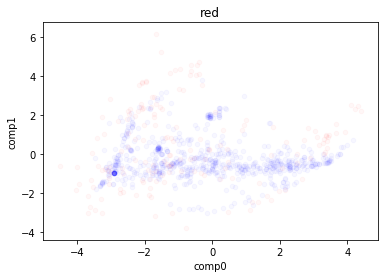

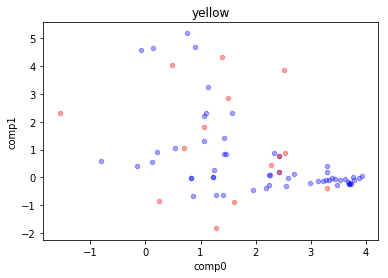

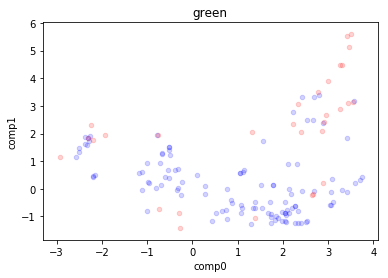

In [8]:
# Separate the datasets into each class, decompose, and mark outliers... might work as a way for cleaning up the data?
goods = {}
bads = {}
ncomps = 10
for color in ['red', 'yellow', 'green']:
    iscolor = annotations['label'] == 'traffic_light-' + color
    raw = color_histograms[iscolor]
    pls = PLSRegression(n_components=ncomps).fit(color_histograms, iscolor.astype(int))
    comp = pd.DataFrame(pls.transform(raw), columns=['comp' + str(n) for n in range(ncomps)], index=raw.index)
    detector = IsolationForest().fit(comp)
    comp['outlier'] = detector.decision_function(comp)
    p = np.percentile(comp['outlier'].values, 20)
    comp_norms = comp[comp['outlier'] >= p]
    comp_outs = comp[comp['outlier'] <= p]
    ax = comp_norms.plot(kind='scatter', x='comp0', y='comp1', alpha=25/len(raw.index), title=color, color='blue')
    comp_outs.plot(kind='scatter', x='comp0', y='comp1', alpha=25/len(raw.index), title=color, color='red', ax=ax)
    goods[color] = comp_norms.index.tolist()
    bads[color] = comp_outs.index.tolist()

red  GOODS


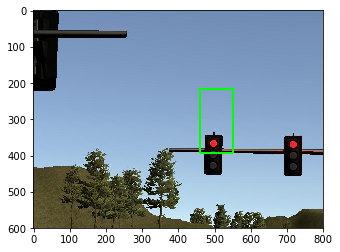

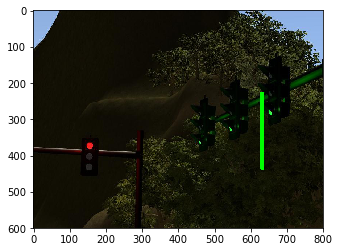

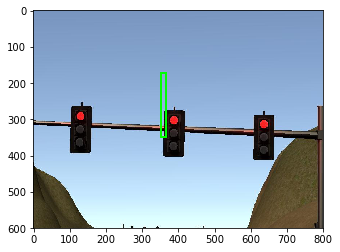

red  BADS


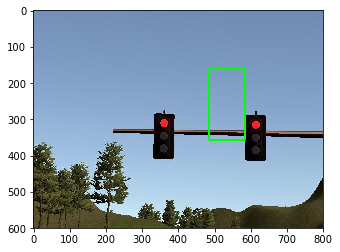

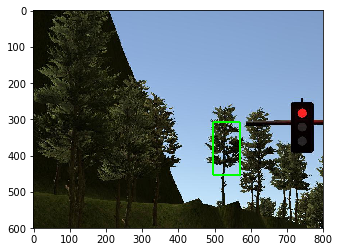

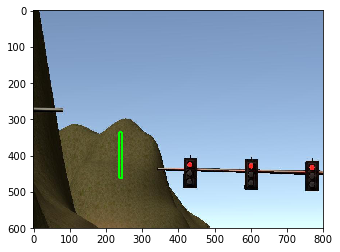

yellow  GOODS


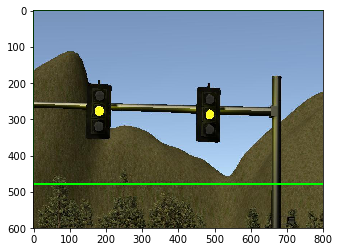

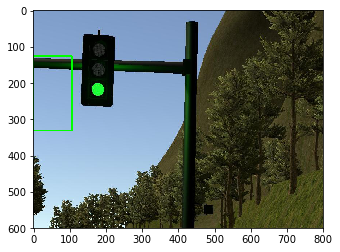

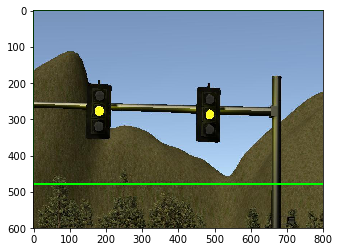

yellow  BADS


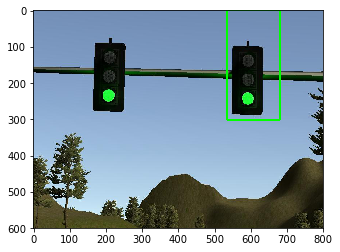

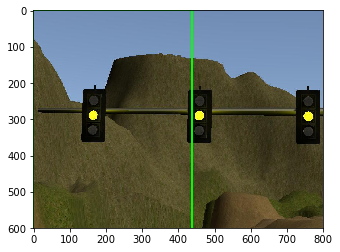

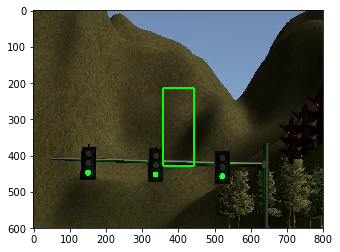

green  GOODS


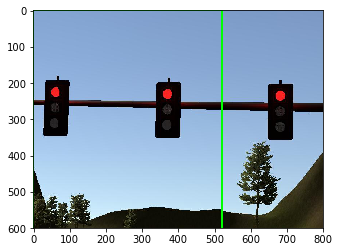

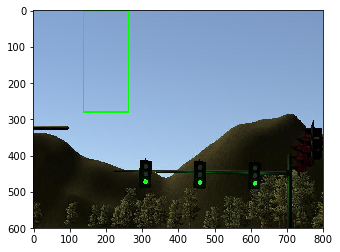

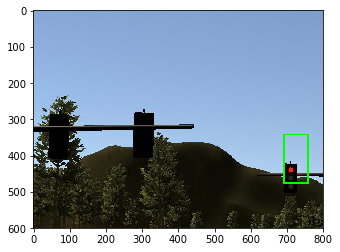

green  BADS


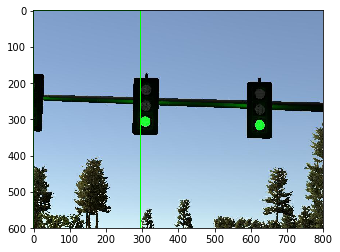

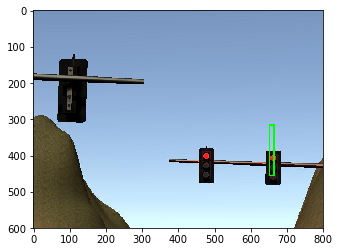

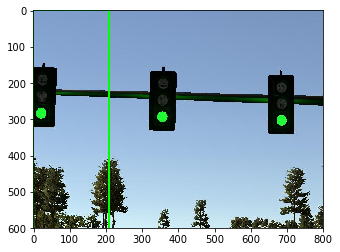

In [9]:
# Sample from each category and show with a rectangle drawn
for color in ['red', 'yellow', 'green']:
    print(color, " GOODS")
    for x in range(3):
        sample = random.choice(goods[color])
        draw_rect_image(sample)
    
    print(color, " BADS")
    for x in range(3):
        sample = random.choice(bads[color])
        draw_rect_image(sample)